In [1]:
!nvidia-smi

Tue Jan  2 10:23:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.36                 Driver Version: 546.33       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2070 ...    On  | 00000000:01:00.0  On |                  N/A |
| N/A   52C    P8              17W /  80W |   4049MiB /  8192MiB |     27%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Installing basic toolkit

In [2]:
!pip install accelerate transformers safetensors opencv-python diffusers -qq

In [3]:
!pip install -qq opencv-contrib-python
!pip install -qq controlnet_aux

# Using Canny control conditions

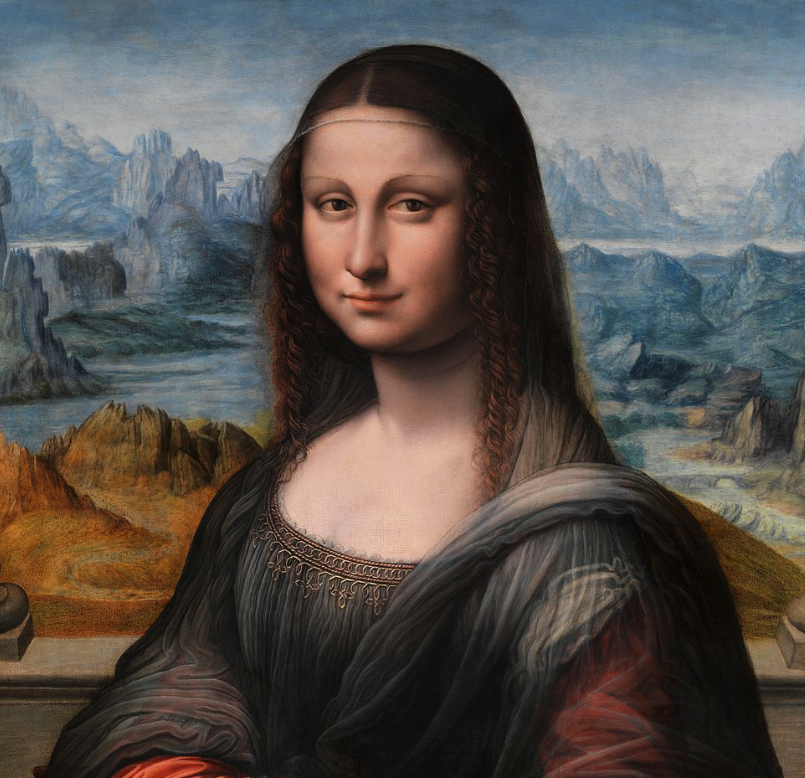

In [4]:
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

# Use Mona Lisa image as original image to extract canny edges. You can also replace with your own image link; or upload a local image to Colab.
image = load_image(
    "https://ice.frostsky.com/2023/08/26/2c809fbfcb030dd8a97af3759f37ee29.png"
)
image

# Use canny operator to extract edges

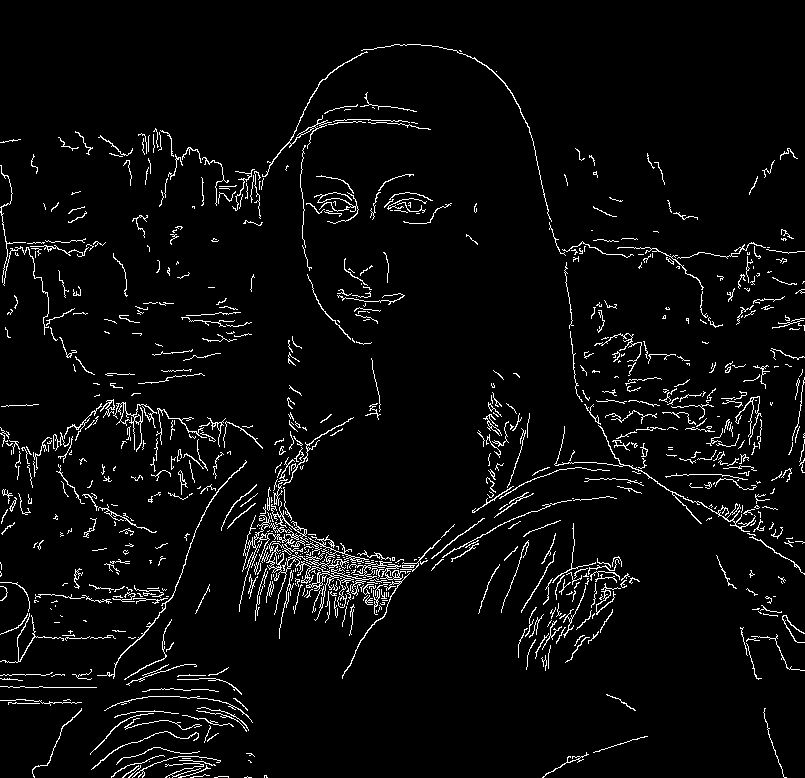

In [5]:
# Import needed libraries
import cv2              # OpenCV library for image processing
from PIL import Image   # Image module in PIL library for image reading and processing
import numpy as np      # NumPy library for array and matrix operations

# Convert image to NumPy array type for easier subsequent operations
image = np.array(image)

# Set low and high threshold values for Canny edge detection algorithm
low_threshold = 100
high_threshold = 200

# Use Canny algorithm for edge detection. Points in image exceeding threshold are marked as edge points by OpenCV
image = cv2.Canny(image, low_threshold, high_threshold)

# Since Canny edge detection output is 2D, add a dimension in the third dimension, for conversion to RGB image
image = image[:, :, None]

# Duplicate single channel image three times to generate three channel (RGB) image
image = np.concatenate([image, image, image], axis=2)

# Use Image module in PIL library to convert NumPy array type to Image type, for easier subsequent image save and display operations
canny_image = Image.fromarray(image)

canny_image

# Download and load SD1.5 model, ControlNet's canny model

In [ ]:
# Load SDXL model and ControlNet's canny model
from diffusers import ControlNetModel, StableDiffusionXLControlNetPipeline, AutoencoderKL
from diffusers.utils import load_image
from PIL import Image
import torch
import numpy as np
import cv2

# ControlNet strength parameter
controlnet_conditioning_scale = 0.5  # recommended for good generalization

controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-canny-sdxl-1.0-small",
    torch_dtype=torch.float16
)
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    controlnet=controlnet,
    vae=vae,
    torch_dtype=torch.float16,
)
pipe.enable_model_cpu_offload()

In [ ]:
# For displaying images
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

# Can replace with your own prompt
prompt = ["a photo of a girl, best quality, super photorealistic"]*2
generator = torch.manual_seed(1024)

# Use ControlNet to complete AI painting
controlnet_conditioning_scale = 0.6

images = pipe(
    prompt, num_inference_steps=50, negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * len(prompt),
    image=canny_image, controlnet_conditioning_scale=controlnet_conditioning_scale, generator=generator
).images

image_grid(images, 1, 2)

# Using human pose control

In [ ]:
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

# You can also replace with your own image link; or upload a local image to Colab.
image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)
image



In [ ]:
from controlnet_aux import OpenposeDetector
from PIL import Image

# Load openpose extraction model
model = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# Extract limb poses
pose = model(image)
pose

In [ ]:
from diffusers import StableDiffusionXLControlNetPipeline, ControlNetModel

# Load ControlNet-openpose
controlnet = ControlNetModel.from_pretrained("thibaud/controlnet-openpose-sdxl-1.0", torch_dtype=torch.float16)
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", controlnet=controlnet, torch_dtype=torch.float16
)
pipe.enable_model_cpu_offload()

In [ ]:
# For displaying images
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid



# Can change to whatever prompt you want to use
prompt = "Darth vader dancing in a desert, high quality"
negative_prompt = "low quality, bad quality"
images = pipe(
    prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=25,
    num_images_per_prompt=2,
    image=pose.resize((1024, 1024)),
    generator=torch.manual_seed(97),
).images
image_grid(images, 1, 2)